In [119]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5

from joblib import Parallel, delayed

In [106]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [107]:
sn = {}
for num in [0, 10, 20]:
    sn[num] = arepo.Snapshot(basepath + '/runs/MW4iso_fg0.2_MHG0.15_RC9/lvl4/output/', num, combineFiles=True)

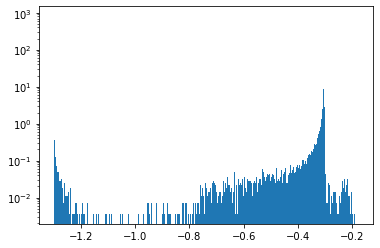

In [114]:
plt.hist(np.log10(sn[10].GFM_Metallicity/0.0127), bins=1000, density=True);
plt.yscale('log')
# plt.ylim(0, 20)

In [115]:
sn = {}
for num in [0, 10, 20]:
    sn[num] = arepo.Snapshot(basepath + '/runs/MW4_MHG0.15_GSE6_kick120/lvl4/output/', num, combineFiles=True)

In [117]:
np.log10(np.unique(sn[0].part0.GFM_Metallicity/0.0127))

array([-1.3       , -1.2       , -0.29999998], dtype=float32)

In [118]:
for metal in np.unique(sn[0].part0.GFM_Metallicity):
    print(np.sum(sn[0].part0.mass[ sn[0].part0.GFM_Metallicity == metal]))

2.0711462
0.11687059
0.14974424


In [4]:
def get_total_metal(sn):
    metal_tot = 0.0
    
    metal_gas = sn.part0.GFM_Metallicity * sn.part0.mass
    metal_tot += np.sum(metal_gas)
    
    if sn.NumPart_Total[4] > 0:
        metal_star = sn.part4.GFM_Metallicity * sn.part4.mass
        metal_tot += np.sum(metal_star)
    
    return metal_tot

In [7]:
print(get_total_metal(sn[0]))
print(get_total_metal(sn[10]))
print(get_total_metal(sn[20]))

0.0018199216574430466
0.0018224338755317149
0.001843982554419199


In [9]:
yields = h5.File('/n/holystore01/LABS/hernquist_lab/Users/abeane/ArepoTables/Arepo_GFM_Tables/Yields/SNII.hdf5',
                mode = 'r')

In [13]:
yields['Masses'][:]

array([  6.,   7.,   9.,  12.,  15.,  20.,  30.,  40.,  60., 100., 120.],
      dtype=float32)

In [15]:
yields['Metallicities'][:]

array([0.0004, 0.004 , 0.008 , 0.02  , 0.05  ], dtype=float32)

In [25]:
yields['Yields']['Z_0.008']['Total_Metals'][:]

array([1.110120e-03, 2.870260e-03, 6.641900e-01, 1.266460e+00,
       2.118260e+00, 3.955360e+00, 3.938660e+00, 3.119370e+00,
       1.262090e+01, 2.356756e+01, 2.980080e+01], dtype=float32)

In [28]:
yields['Yield_names'][:]

array([b'Z_0.0004', b'Z_0.004', b'Z_0.008', b'Z_0.02', b'Z_0.05'],
      dtype=object)

## check snapshots

In [29]:
name = 'MW4iso_fg0.2_MHG0.15_RC9'

In [49]:
sn = {}
sn_hvy = {}
num_list = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950,
            1000, 1050, 1100, 1150, 1200]
for num in tqdm(num_list):
    try:
        sn[num] = arepo.Snapshot(basepath + 'runs/MW4iso_fg0.2_MHG0.15_RC9/lvl4/output', num, combineFiles=True)
    except:
        pass

    try:
        sn_hvy[num] = arepo.Snapshot(basepath + 'runs/MW4iso_fg0.2_MHG0.25_RC9/lvl4/output', num, combineFiles=True)
    except:
        pass

100%|██████████| 25/25 [01:49<00:00,  4.36s/it]


In [70]:
def get_evol(sn, Rmin=4, Rmax=8, zmax=3):

    center = np.array([200, 200, 200])

    time = []
    mass = []
    metal_mass = []
    sfr_dens = []
    
    area = np.pi*(Rmax**2 - Rmin**2)

    for num in sn.keys():
        pos = sn[num].part0.pos.value - center
        R = np.linalg.norm(pos[:,:2], axis=1)
        z = pos[:,2]
    
        in_SN = np.logical_and(R < Rmax, R > Rmin)
        in_SN = np.logical_and(in_SN, np.abs(z) < zmax)
        # print(len(np.where(in_disk)[0]))
    
        mass_ = sn[num].part0.mass.value[in_SN]
        mass_ = np.sum(mass_)
    
        metal_mass_ = sn[num].part0.mass.value[in_SN] * sn[num].part0.GFM_Metallicity[in_SN]
        metal_mass_ = np.sum(metal_mass_)
        
        sfr_ = np.sum(sn[num].part0.sfr[in_SN])
        
        sfr_dens.append(sfr_/area)
    
        mass.append(mass_)
        metal_mass.append(metal_mass_)
        time.append(sn[num].Time.value)

    out = {}
        
    out['time'] = np.array(time)
    out['mass'] = np.array(mass)
    out['metal_mass'] = np.array(metal_mass)
    out['sfr_dens'] = np.array(sfr_dens)

    return out

In [71]:
evol = get_evol(sn)
evol_hvy = get_evol(sn_hvy)

(-1.0, 0.0)

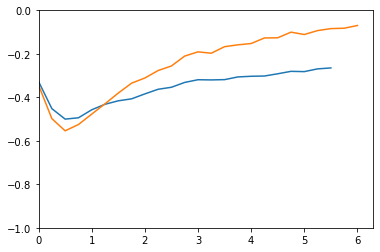

In [72]:
plt.plot(evol['time'], np.log10((evol['metal_mass']/evol['mass'])/0.0127))

plt.plot(evol_hvy['time'], np.log10((evol_hvy['metal_mass']/evol_hvy['mass'])/0.0127))

plt.xlim(0, None)
plt.ylim(-1, 0)

<ipython-input-76-1caed884517c>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(evol['time'], np.log10(10*evol['sfr_dens']))
<ipython-input-76-1caed884517c>:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(evol_hvy['time'], np.log10(10*evol_hvy['sfr_dens']))


(-4.0, -1.0)

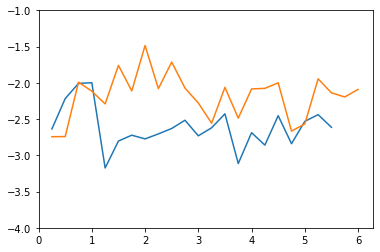

In [76]:
plt.plot(evol['time'], np.log10(10*evol['sfr_dens']))
plt.plot(evol_hvy['time'], np.log10(10*evol_hvy['sfr_dens']))


# plt.plot(evol_hvy['time'], )

plt.xlim(0, None)
# plt.ylim(-1, 0)
plt.ylim(-4, -1)

In [52]:
sfr = np.genfromtxt(basepath + 'runs/MW4iso_fg0.2_MHG0.15_RC9/lvl4/output/sfr.txt')
sfr_hvy = np.genfromtxt(basepath + 'runs/MW4iso_fg0.2_MHG0.25_RC9/lvl4/output/sfr.txt')

In [53]:
def bin_sfr(t, sfr, bin_width=0.01):
    bin_left = 0.0
    bin_right = bin_left + bin_width
    
    ave_sfr = []
    ave_t = []
    
    max_val = np.max(t)
    while bin_left < max_val:
        key = np.logical_and(t >=bin_left, t<bin_right)
        ave_sfr.append(np.mean(sfr[key]))
        ave_t.append(np.mean(t[key]))
        
        bin_left += bin_width
        bin_right += bin_width
        
    return np.array(ave_t), np.array(ave_sfr)

In [56]:
avet, avesfr = bin_sfr(sfr[:,0], sfr[:,2], bin_width=0.05)
avet_hvy, avesfr_hvy = bin_sfr(sfr_hvy[:,0], sfr_hvy[:,2], bin_width=0.05)

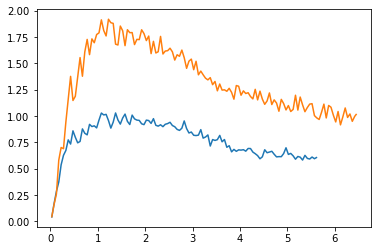

In [60]:
plt.plot(avet, avesfr)
plt.plot(avet_hvy, avesfr_hvy)

### CGM accretion

In [101]:
acciso = np.load(basepath+'/anlys/CGMacc/acc_MW4iso_fg0.2_MHG0.15_RC9-lvl4.npy', allow_pickle=True).item()
acc = np.load(basepath+'/anlys/CGMacc/acc_MW4_MHG0.15_GSE6_kick-lvl4.npy', allow_pickle=True).item()

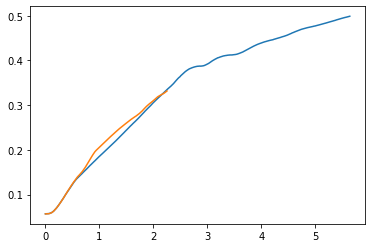

In [102]:
plt.plot(acciso['Time'], acciso['Menc'][:,0])
plt.plot(acc['Time'], acc['Menc'][:,0])

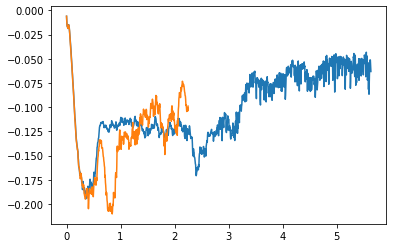

In [103]:
plt.plot(acciso['Time'], acciso['Mdotin'][:,0])
plt.plot(acc['Time'], acc['Mdotin'][:,0])

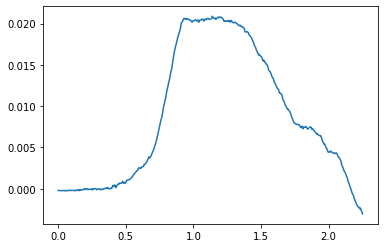

In [104]:
plt.plot(acc['Time'], acc['Menc'][:,0]-acciso['Menc'][:,0][acciso['Time'] <= acc['Time'][-1]])

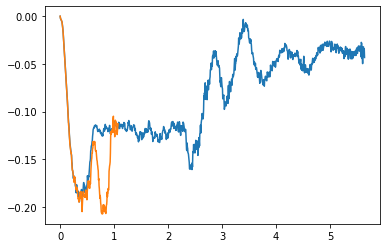

In [93]:
plt.plot(acciso['Time'], acciso['Mdotout'][:,0]+acciso['Mdotin'][:,0])
plt.plot(acc['Time'], acc['Mdotout'][:,0]+acc['Mdotin'][:,0])

In [96]:
center = np.array([200, 200, 200])
pos = sn[0].part0.pos.value - center
R = np.linalg.norm(pos[:,:2], axis=1)
z = pos[:,2]

in_SN = np.logical_and(R > 6, R < 10)
in_SN = np.logical_and(in_SN, np.abs(z) < 3)

print(np.sum(sn[0].part0.mass[in_SN]))


0.027409002


In [98]:
2 * np.sum(sn[0].part0.mass.value[in_SN]) * 1E10/1E9

0.5481800436973572